In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_formatting import *

import pandas as pd
import numpy as np
import datetime as dt
import itertools as it
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.patheffects as path_effects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
%matplotlib inline

### Helper functions and variables

In [2]:
def get_ci(df, col, gb_col='date', percentile='95'):
    if percentile == '999':
        cival = 3.291
    if percentile == '995':
        cival = 2.807
    if percentile == '99':
        cival = 2.576
    if percentile == '95':
        cival = 1.96
    if percentile == '90':
        cival = 1.645
    if percentile == '80':
        cival = 1.282

    df_stats = df.groupby(gb_col)[col].agg([np.nanmean,'count',np.nanstd])
    ci95_hi = []
    ci95_lo = []
    for i in df_stats.index:
        m, c, s = df_stats.loc[i]
        ci95_hi.append(m + cival*s/np.sqrt(c))
        ci95_lo.append(m - cival*s/np.sqrt(c))
    df_stats['ci95_hi'] = ci95_hi
    df_stats['ci95_lo'] = ci95_lo

    return df_stats.reset_index()

In [3]:
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',
                   4:'Friday',5:'Saturday',6:'Sunday'}
month_abbrev = {'08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec','01':'Jan',
                '02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun','07':'Jul'}

now = datetime.now()
today = now.strftime("%Y-%m-%d")
start = '2020-08-01'
final = '2021-05-15'

alldates = pd.date_range(start=start, end=final).tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
date_dict = dict(zip(DATE_DF['date'].values, list(range(len(DATE_DF['date'].values)))))
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()

In [4]:
fs = 9
lw = 2.8
wid = 3
cols = ["#515d6c","#6e8755","#81bdcc"]

pe1 = [path_effects.Stroke(linewidth=1.5,foreground='w'),path_effects.Normal()]
pe2 = [path_effects.Stroke(linewidth=lw*1.5,foreground='w',alpha=0.9),path_effects.Normal()]

dates_tt = ['2020-08-01','2020-09-01','2020-10-01','2020-11-01','2020-12-01',
            '2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01']
dates_ll = ['Aug','Sep','Oct','Nov','Dec','2021','Feb','Mar','Apr','May']

### In Massachusetts, we have the benefit case data from $cities$ instead of counties
- Additionally, we have data from most colleges in Massachusetts

This gives us a much better lens through which we can study the effect of testing.

**Source: https://www.mass.gov/info-details/covid-19-response-reporting**

In [5]:
ihe_df    = pd.read_csv('../data/campus_covid_fall2020_full.csv', dtype={'ipeds_id':str, 'fips':str})
ipeds_df  = pd.read_csv('../data/campus_covid_ipeds.csv',         dtype={'ipeds_id':str, 'fips':str})
status_df = pd.read_csv('../data/campus_covid_status.csv',        dtype={'ipeds_id':str, 'fips':str})
census_df = pd.read_csv('../data/campus_covid_census.csv',        dtype={'fips':str})
jhu_df    = pd.read_csv('../data/campus_covid_jhu_county.csv.gz', dtype={'fips':str})

ma_df = pd.read_csv('../data/massachusetts_ihes.csv',dtype={'ipeds_id':'str','fips':'str'})
cumadf = pd.read_csv('../data/massachusetts_ihes_cumulative.csv',dtype={'ipeds_id':'str','fips':'str'})
city_df = pd.read_csv('../data/massachusetts_city.csv')

# ... and this is silly, but get the school's branding and colors etc.
school_deets = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
                   '1lDz0KAC_ySX48--StNq6tOySKf-WV2dO2vKLDi3u7rI/gviz/tq?tqx=out:csv&sheet=refs')

#### Assign each city to a "testing frequency" bin according to the per-student testing at its IHEs 

In [6]:
city_ihe_df = cumadf.groupby('city').agg({'cumulative_tests':'sum',
                                          'enrollment':'sum',
                                          'ipeds_id':'count'}).reset_index()
num_weeks = cumadf['week'].unique()[0]
city_ihe_df['cumulative_tests_per_enrollment'] = city_ihe_df['cumulative_tests'] /\
                                                 city_ihe_df['enrollment'] / num_weeks
out = []
for i in city_ihe_df['cumulative_tests_per_enrollment']:
    if i > 0.75:
        v = 'more than 3 tests per month'
    elif i < 0.25:
        v = 'less than 1 test per month'
    elif i >= 0.25 and i < 0.75:
        v = 'between 1-3 tests per month'

    out.append(v)

city_ihe_df['test_cat'] = out

# merge this information back into the case counts time series from the state
city_df = city_df.loc[city_df['city'].isin(cumadf['city'])].copy()
city_df = city_df.merge(DATE_DF[['date','week']], how='left', on='date')
city_df = city_df.merge(city_ihe_df, how='left', on='city')

city_dfg = city_df.groupby(['test_cat','date']).agg({'new_tests_town':'sum',
            'new_cases_town':'sum', 'population':'sum','enrollment':'sum',
            'cumulative_tests':'sum','ipeds_id':'sum'}).reset_index()

#### Do the same, but for IHEs

In [7]:
out = []
for i in cumadf['cumulative_tests_per_enrollment']:
    if i/39 >= 0.75:
        v = 'more than 3 tests per month'
    elif i/39 < 0.25:
        v = 'less than 1 test per month'
    elif i/39 >= 0.25 and i/39 < 0.75:
        v = 'between 1-3 tests per month'
    out.append(v)

cumadf['test_cat'] = out

### Aggregate to weekly case data for IHEs to match city data

In [8]:
ma_df['new_cases'] = ma_df.groupby('ipeds_id')['positive_tests'].rolling(window=7).mean().values
ma_dfg = ma_df.groupby(['name','ipeds_id','week','city','fips',
                        'enrollment_fulltime']).agg({'positive_tests':'sum','total_tests':'sum',
                                                     'new_cases':'sum','date':'min'}).reset_index()
ma_dfg = ma_dfg.loc[ma_dfg['date']>'2020-08-01'].copy()
ma_dfg = ma_dfg.merge(cumadf[['ipeds_id','test_cat']], how='left', on='ipeds_id')

cat_ma_dfg = ma_dfg.groupby(['test_cat','date']).agg({'total_tests':'sum','positive_tests':'sum',
                                  'new_cases':'sum','enrollment_fulltime':'sum'}).reset_index()

# Plot

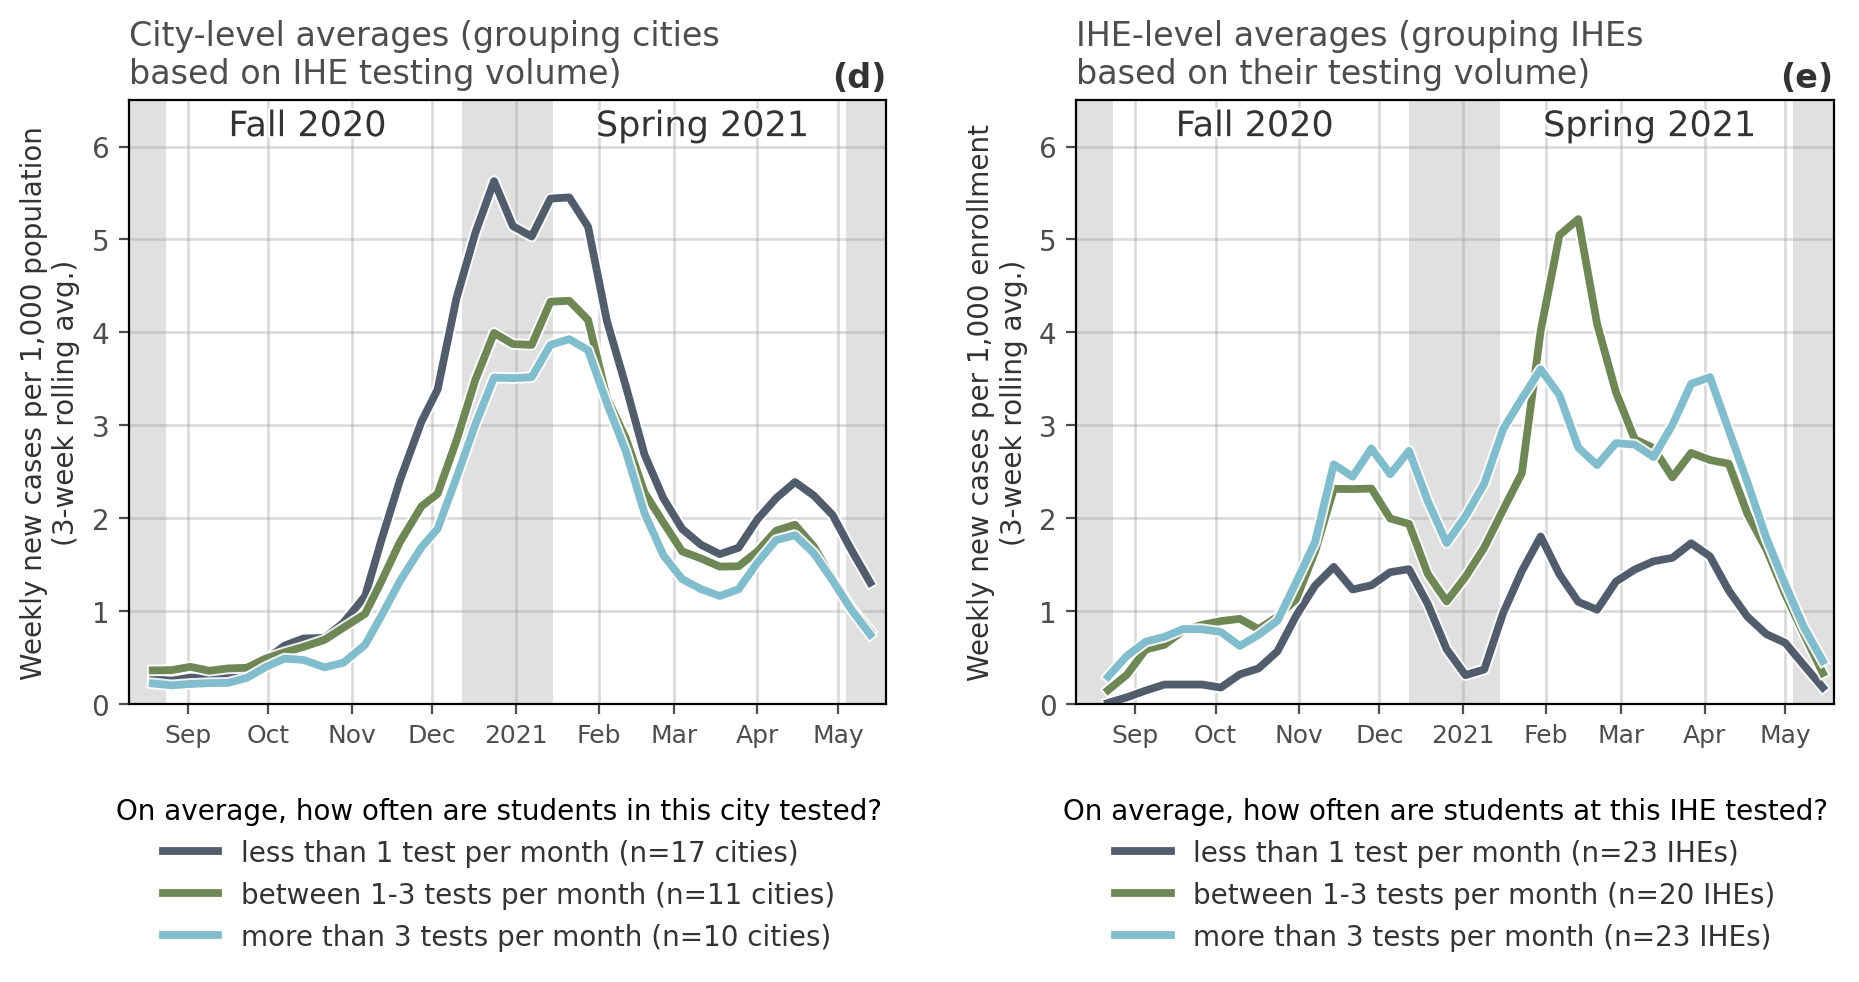

In [9]:
fig, ax = plt.subplots(1,2,figsize=(11,4),dpi=200)
plt.subplots_adjust(wspace=0.25)

for ti,tc in enumerate(['less than 1 test per month', 'between 1-3 tests per month',
                        'more than 3 tests per month']):
    dfi = get_ci(city_df.loc[city_df['test_cat']==tc].copy(), 'new_cases_town', ['test_cat','date'])
    dfi = dfi.loc[dfi['date']<final].copy()
    dpi = get_ci(city_df.loc[city_df['test_cat']==tc].copy(), 'population', ['test_cat','date'])
    dpi = dpi.loc[dpi['date']<final].copy()
    yvals_i = (dfi['nanmean'] / dpi['nanmean']).values * 1000
    xvals_i = [date_dict[i] for i in dfi['date']]
    ax[0].plot(xvals_i, pd.Series(yvals_i).rolling(window=wid).mean(),
               label=tc+" (n=%i cities)"%int(dfi['count'].mean()), color=cols[ti], lw=lw,
               path_effects=pe2)

    dfi = get_ci(ma_dfg.loc[ma_dfg['test_cat']==tc].copy(), 'positive_tests', ['test_cat','date'])
    dpi = get_ci(ma_dfg.loc[ma_dfg['test_cat']==tc].copy(), 'enrollment_fulltime', ['test_cat','date'])
    yvals_i = (dfi['nanmean'] / dpi['nanmean']).values * 1000
    xvals_i = [date_dict[i] for i in dfi['date']]
    ax[1].plot(xvals_i, pd.Series(yvals_i).rolling(window=wid).mean(),
               label=tc+" (n=%i IHEs)"%int(dfi['count'].mean()), color=cols[ti], lw=lw,
               path_effects=pe2)

ax[0].set_ylabel('Weekly new cases per 1,000 population\n(%i-week rolling avg.)'%wid, color='.2')
ax[1].set_ylabel('Weekly new cases per 1,000 enrollment\n(%i-week rolling avg.)'%wid, color='.2')
ax[0].set_title('City-level averages (grouping cities\nbased on IHE testing volume)',
                x=0,color='.3',ha='left')
ax[1].set_title('IHE-level averages (grouping IHEs\nbased on their testing volume)',
                x=0,color='.3',ha='left')

letts = ['(d)','(e)']
college_labs = ['in this city','at this IHE']
for ai,a in enumerate(fig.axes):
    a.text(1.0, 1.01, letts[ai], ha='right', va='bottom', transform=a.transAxes,
       fontweight='bold', fontsize='large', color='.2')

    a.set_xticks([date_dict[i] for i in dates_tt])
    a.set_xticklabels(dates_ll, fontsize=fs)
    a.fill_between([date_dict['2020-08-24'], date_dict[start]], -1, 7,
                   color='.7', alpha=0.4, zorder=0, lw=0)
    a.fill_between([date_dict['2021-05-04'], date_dict[final]+7], -1, 7,
                   color='.7', alpha=0.4, zorder=0, lw=0)
    a.fill_between([date_dict['2020-12-12'], date_dict['2021-01-15']], -1, 7,
                   color='.7', alpha=0.4, zorder=0, lw=0)
    a.text(date_dict['2020-10-16']-0.5,6.5*0.985,'Fall 2020',
           ha='center',va='top',fontsize=fs*1.4,color='.2',path_effects=pe1)
    a.text(date_dict['2021-03-12']-0.5,6.5*0.985,'Spring 2021',
           ha='center',va='top',fontsize=fs*1.4,color='.2',path_effects=pe1)
    l = a.legend(loc=3, ncol=1, bbox_to_anchor=[-0.05, -0.45], framealpha=0,
                 title='On average, how often are students %s tested?'%college_labs[ai])
    for text in l.get_texts():
        text.set_color('.2')

    a.set_ylim(-0.0,6.5)
    a.set_xlim(date_dict['2020-08-15']-5,date_dict['2021-05-12']+7)
    a.tick_params(labelcolor='.3', color='.3')
    a.grid(linewidth=1.0, color='.6', alpha=0.35)

# plt.savefig('../figs/pngs/massachusetts_testing_x1.png',dpi=425,bbox_inches='tight')
# plt.savefig('../figs/pdfs/massachusetts_testing_x1.pdf',bbox_inches='tight')
plt.show()

___________

### If you want to retrieve data from the Google Sheets directly, run the following code

In [10]:
# keep_ipeds = school_deets.loc[school_deets['data']=='yes']['name'].values

# # span through each google sheet and append it to a single dataframe
# badd = []
# mout = []
# for b in keep_ipeds:
#     burl = b.replace(" ",'%20')
#     try:
#         mass_d = pd.read_csv('https://docs.google.com/spreadsheets/d/'+\
#            '1lDz0KAC_ySX48--StNq6tOySKf-WV2dO2vKLDi3u7rI/gviz/tq?tqx=out:csv&sheet=%s'%burl)
#         mass_d = mass_d[['date','total_tests','positive_tests',
#                          'college','url','ipeds_id','notes']].copy()
#         deets_d = school_deets.loc[\
#                        school_deets['ipeds_id']==mass_d['ipeds_id'].values[0]].copy()

#         mass_dx = DATE_DF.copy()
#         mass_dx['university'] = mass_d['college'].dropna().unique()[0]

#         mass_dx['url'] = mass_d['url'].dropna().unique()[0]
#         mass_dx = mass_dx.merge(mass_d[['date','total_tests','positive_tests','notes']],
#                                 how='left',on='date')
#         mass_dx['total_tests'] = np.nan_to_num(mass_dx['total_tests'])
#         mass_dx['positive_tests'] = np.nan_to_num(mass_dx['positive_tests'])
#         tt = mass_dx['total_tests'].astype(str).str.replace(',','').astype(float)
#         mass_dx['total_tests'] = tt
#         mass_dx['total_tests'] = np.nan_to_num(mass_dx['total_tests'])
#         mass_d = mass_dx.loc[(mass_dx['date']<=today)&(mass_dx['date']>=start)].copy()
#         mout.append(mass_d)
#     except:
#         print("something's up with",b)
#         badd.append(b)

# mass_data = pd.concat(mout).reset_index().iloc[:,1:]
# mass_g = mass_data.groupby(['week','university']).agg({
#                             'date':'min','total_tests':'sum',
#                             'positive_tests':'sum'}).reset_index()

# mass_data = mass_data.rename(columns={'university':'name'}).merge(school_deets[['ipeds_id','name',
#                                                   'abbrev','city','fips']], how='left', on='name')
# mass_data['ipeds_id'] = mass_data['ipeds_id'].astype(str)
# mass_data = mass_data.merge(status_df[['ipeds_id','status', 'status_merge','enrollment_fulltime','ihe_fulltime_population']],
#                 how='left',on='ipeds_id')
# mass_deets = mass_data[['name', 'ipeds_id', 'city', 'fips', 'status', 'status_merge',
#            'enrollment_fulltime', 'ihe_fulltime_population']].drop_duplicates().reset_index().iloc[:,1:]

In [11]:
# ma_df = mass_data[['date','week','ipeds_id','name','city','fips','total_tests',
#                    'positive_tests','enrollment_fulltime','ihe_fulltime_population',
#                    'status','status_merge']].copy()
# cumadf = ma_df.groupby(['ipeds_id']).agg({'total_tests':'sum',
#                                           'positive_tests':'sum',
#                                           'week':'max'}).reset_index()
# cumadf = cumadf.rename(columns={'total_tests':'cumulative_tests',
#                                 'positive_tests':'cumulative_cases'})
# ma_df = ma_df.merge(cumadf[[i for i in cumadf.columns if i != 'week']],
#                     how='left', on='ipeds_id')

In [12]:
# fix_enrollments = {'National Aviation Academy of New England':296,
#                    'Northpoint Bible College':237,
#                    'University of Massachusetts Medical School Worcester':1185}
# for f, v in fix_enrollments.items():
#     ma_df.loc[ma_df['name']==f, 'enrollment_fulltime'] = v

In [13]:
# school_deets = school_deets.copy()
# school_deets['ipeds_id'] = school_deets['ipeds_id'].astype(str)

In [14]:
# ma_df = ma_df.merge(school_deets[['ipeds_id','enrollment','public_private','testing_fall2020',
#                                   'testing_spring2021']], how='left', on='ipeds_id')

In [15]:
# ma_df['total_tests_per_1000_enrollment']      = ma_df['total_tests'] / ma_df['enrollment_fulltime'] * 1000
# ma_df['positive_tests_per_1000_enrollment']   = ma_df['positive_tests'] / ma_df['enrollment_fulltime'] * 1000
# ma_df['cumulative_cases_per_1000_enrollment'] = ma_df['cumulative_cases'] / ma_df['enrollment_fulltime'] * 1000
# ma_df['cumulative_tests_per_1000_enrollment'] = ma_df['cumulative_tests'] / ma_df['enrollment_fulltime'] * 1000

# ma_df['total_tests'] = ma_df['total_tests'].astype(int)
# ma_df['positive_tests'] = ma_df['positive_tests'].astype(int)
# ma_df['enrollment_fulltime'] = ma_df['enrollment_fulltime'].astype(int)

# ma_df = ma_df.sort_values(['name','date'])

# ma_df = ma_df[['date','week','name','ipeds_id','total_tests','positive_tests',
#                'cumulative_cases','cumulative_tests','testing_fall2020','status','status_merge',
#                'total_tests_per_1000_enrollment','positive_tests_per_1000_enrollment',
#                'cumulative_cases_per_1000_enrollment','cumulative_tests_per_1000_enrollment',
#                'enrollment_fulltime','fips','city']].reset_index().iloc[:,1:]

In [16]:
# cumadf = cumadf.merge(school_deets[['ipeds_id','enrollment', 'city', 'fips']],
#                       how='left',on='ipeds_id')
# cumadf = cumadf.merge(ma_df[['ipeds_id','status','status_merge']].drop_duplicates(),
#                       how='left',on='ipeds_id')

In [17]:
# cumadf['cumulative_cases_per_enrollment'] = cumadf['cumulative_cases'] / cumadf['enrollment']
# cumadf['cumulative_tests_per_enrollment'] = cumadf['cumulative_tests'] / cumadf['enrollment']
# cumadf['cumulative_cases_per_enrollment_per_week'] = cumadf['cumulative_cases_per_enrollment'] / cumadf['week']
# cumadf['cumulative_tests_per_enrollment_per_week'] = cumadf['cumulative_tests_per_enrollment'] / cumadf['week']

In [18]:
# # use creds to create a client to interact with the Google Drive API
# scope = ['https://spreadsheets.google.com/feeds',
#          'https://www.googleapis.com/auth/drive']

# creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
# client = gspread.authorize(creds)

# mass_data = client.open("COVID-data_Massachusetts")
# city_data = mass_data.worksheet('new_town_data')
# city_df = pd.DataFrame(city_data.get_all_records(default_blank=np.nan))